In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import climate_learn as cl
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import rankdata
import torch

In [3]:
dm = cl.data.IterDataModule(
    "downscaling",
    os.environ["ERA5_5DEG"],
    os.environ["ERA5_2DEG"],
    ["2m_temperature", "temperature_850", "geopotential_500"],
    ["2m_temperature"],
    src="era5",
    history=1
)
dm.setup()

In [4]:
model = cl.load_downscaling_module(data_module=dm, preset="resnet")
checkpoint = "../checkpoints/resnet_downscaling_t2m/checkpoints/last.ckpt"
model = cl.LitModule.load_from_checkpoint(checkpoint, net=model.net)

Loading preset: resnet
Using preset optimizer
Using preset learning rate scheduler
Loading training loss: mse
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation transform: denormalize
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize


ModuleNotFoundError: No module named 'climate_learn.utils.datetime'

In [6]:
for batch in dm.test_dataloader():
    break

In [7]:
x, y = batch[:2]

In [15]:
ensemble_forecast = cl.utils.get_monte_carlo_predictions(
    x.to(device="cuda:2"),
    mm.to(device="cuda:2"),
    50
)

In [16]:
ensemble_forecast.shape

torch.Size([50, 64, 3, 32, 64])

In [17]:
var, mean = torch.var_mean(ensemble_forecast, 0)

In [31]:
# Compute rank histogram for 2m_temperature across the batch
channel = variables.index("2m_temperature")
obs = y.detach().cpu().numpy()[:,channel]
print(obs.shape)

(64, 32, 64)


In [32]:
ensemble = ensemble_forecast.detach().cpu().numpy()[:,:,channel]
print(ensemble.shape)

(50, 64, 32, 64)


In [33]:
combined = np.vstack((obs[np.newaxis], ensemble))
print(combined.shape)

(51, 64, 32, 64)


In [34]:
ranks = np.apply_along_axis(lambda x: rankdata(x, method="min"), 0, combined)
print(ranks.shape)

(51, 64, 32, 64)


In [35]:
ties = np.sum(ranks[0] == ranks[1:], axis=0)
print(ties.shape)

(64, 32, 64)


In [36]:
ranks = ranks[0]
tie = np.unique(ties)
print(tie)

[0]


In [37]:
for i in range(1, len(tie)):
    idx = ranks[ties == tie[i]]
    ranks[ties == tie[i]] = [
        np.random.randint(idx[j], idx[j] + tie[i] + 1, tie[i])[0]
        for j in range(len(idx))
    ]

In [38]:
hist = np.histogram(
    ranks,
    bins=np.linspace(0.5,combined.shape[0]+0.5,combined.shape[0]+1)
)

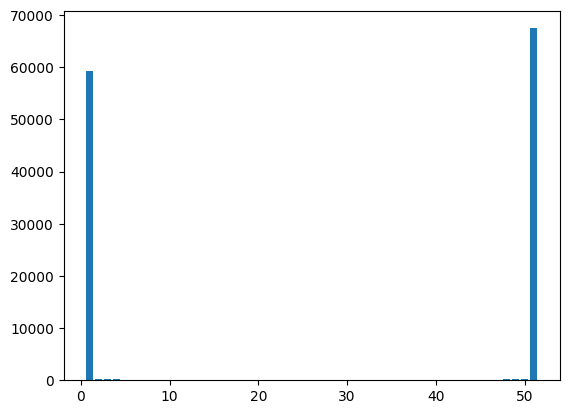

In [39]:
plt.bar(
    range(1, ensemble.shape[0]+2),
    hist[0]
)
plt.show()